In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
#nltk.download('stopwords')
#from keras_tqdm import TQDMNotebookCallback

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import codecs
from tqdm import tqdm

from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, GlobalMaxPool1D, Bidirectional, GlobalMaxPooling1D
from keras.layers import LSTM, GRU, Dropout , BatchNormalization, Embedding, Flatten, GlobalAveragePooling1D, concatenate, Input

Using TensorFlow backend.


In [2]:
#Reading the training data
train = pd.read_csv('Desktop/online_studies/Udacity/ML/capstone/train.csv')
train[train.isnull().any(axis=1)]
train.dropna(inplace=True)
#Labeling the training data
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 11.0+ MB


In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
# Read test data
test = pd.read_csv('Desktop/online_studies/Udacity/ML/capstone/test.csv')
test[test.isnull().any(axis=1)]
test.dropna(inplace=True)

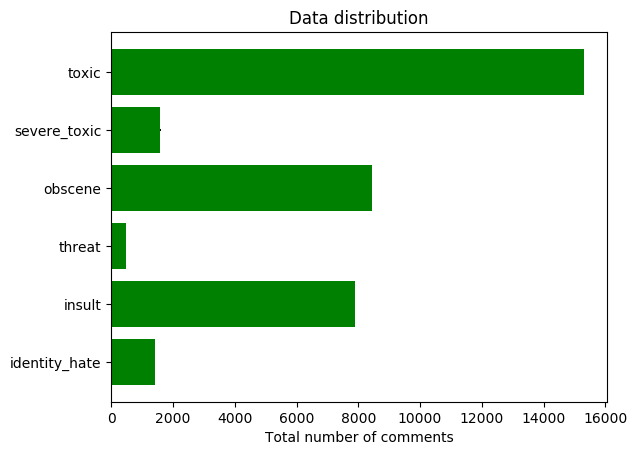

In [7]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
toxic_class = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate')
y_pos = np.arange(len(toxic_class))
value = (train.toxic.sum(),train.severe_toxic.sum(),train.obscene.sum(),train.threat.sum(),train.insult.sum(),train.identity_hate.sum())
error = np.random.rand(len(toxic_class))
ax.barh(y_pos, value, xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(toxic_class)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Total number of comments')
ax.set_title('Data distribution')

plt.show()

In [8]:
train['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
5         "\n\nCongratulations from me as well, use the ...
6              COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7         Your vandalism to the Matt Shirvington article...
8         Sorry if the word 'nonsense' was offensive to ...
9         alignment on this subject and which are contra...
10        "\nFair use rationale for Image:Wonju.jpg\n\nT...
11        bbq \n\nbe a man and lets discuss it-maybe ove...
12        Hey... what is it..\n@ | talk .\nWhat is it......
13        Before you start throwing accusations and warn...
14        Oh, and the girl above started her arguments w...
15        "\n\nJuelz Santanas Age\n\nIn 2002, Juelz Sant...
16        Bye! \n\nDon't look, come or t

In [9]:
# Create tools to preprocess data
# we will remove english stop words from text as well as punctuation
from nltk.corpus import stopwords
porter = PorterStemmer()
stop_words = set(stopwords.words('english')) 

stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
print(stop_words)

{'its', 'down', 've', ',', 'doing', 'all', 'whom', 'been', "'", 'now', 't', 'didn', 'as', 'yours', "wouldn't", 'up', "you'll", 'me', 'themselves', 'a', 'or', 'own', 'she', 'myself', 'in', "won't", 'should', 'over', 'more', 'most', "doesn't", 'm', 'does', 'ain', 'haven', "wasn't", 'only', 'why', "you'd", 'having', 'is', 'both', 'ma', 'of', ')', 'these', 'so', "it's", 'above', 'but', 'by', 'after', "aren't", 'shouldn', 'once', 'herself', 'through', 'itself', 'was', 'any', 'if', 'below', "didn't", 'hadn', 'couldn', 'being', 'into', 'between', 'he', 'until', "isn't", 'against', "shouldn't", 'what', 'do', 'them', "couldn't", 'which', 'll', 'out', "shan't", 'wouldn', ']', 'weren', 'the', 'will', 'ours', "you're", "you've", 'here', 'with', 'from', 'am', 'off', 'under', 'mightn', 'be', '"', 'this', "needn't", 'i', "mightn't", 'his', "should've", 'd', 'than', 'when', 'wasn', 'my', 'it', 'have', 'needn', 'during', 'yourself', 'y', 's', 'some', 'while', 'who', "haven't", 'then', 'won', 'him', 'ar

In [10]:
# the maximum number of words considered is 100000
MAX_NB_WORDS = 100000
# the size of the sentences will be 250
max_seq_len = 250

raw_docs_train = train['comment_text'].tolist()
raw_docs_test = test['comment_text'].tolist()

print(raw_docs_train[0:2])
num_classes = len(list_classes)

num_classes = len(list_classes)

tokenizer = RegexpTokenizer(r'\w+')

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))

processed_docs_train[0:10]

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27", "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"]
pre-processing train data...


100%|██████████| 159571/159571 [00:25<00:00, 6234.13it/s]


['Explanation Why edits made username Hardcore Metallica Fan reverted They vandalisms closure GAs I voted New York Dolls FAC And please remove template talk page since I retired 89 205 38 27',
 'D aww He matches background colour I seemingly stuck Thanks talk 21 51 January 11 2016 UTC',
 'Hey man I really trying edit war It guy constantly removing relevant information talking edits instead talk page He seems care formatting actual info',
 'More I make real suggestions improvement I wondered section statistics later subsection types accidents I think references may need tidying exact format ie date format etc I later one else first preferences formatting style references want please let know There appears backlog articles review I guess may delay reviewer turns It listed relevant form eg Wikipedia Good_article_nominations Transport',
 'You sir hero Any chance remember page',
 'Congratulations well use tools well talk',
 'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK',
 'Your vandalism Ma

In [11]:
print("pre-processing test data...")
processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))

pre-processing test data...


100%|██████████| 153164/153164 [00:22<00:00, 6902.38it/s]


In [12]:
print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

tokenizing input data...
dictionary size:  348520


In [13]:
# summarize what was learned
print(tokenizer.word_counts)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [14]:
print(tokenizer.document_count)

312735


In [15]:
print(tokenizer.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [16]:
#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)
print("Done !!")

Done !!


In [17]:
embed_dim = 300

#Glove embedding
print('loading first word embeddings...')
embeddings_index = {}
f = codecs.open('Desktop/online_studies/Udacity/ML/capstone/glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix_glove = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_glove[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix_glove, axis=1) == 0))

loading first word embeddings...


2196019it [25:05, 1458.45it/s]


found 2196017 word vectors
preparing embedding matrix...
number of null word embeddings: 23510


In [18]:
#Fasttext embedding
print('loading second word embeddings...')
EMBEDDING_FILE = "Desktop/online_studies/Udacity/ML/capstone/crawl-300d-2M.vec"

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8"))

word_index = tokenizer.word_index
embedding_matrix_crawl = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_crawl[i] = embedding_vector

print('Done!!')

loading second word embeddings...


NameError: name 'Print' is not defined

In [23]:
print(embedding_matrix_crawl[1])

[ -4.82100010e-01   8.85000005e-02  -7.81999975e-02  -7.46000037e-02
  -7.41000026e-02  -1.40000004e-02   2.10400000e-01   2.96499997e-01
   1.77800000e-01   2.38600001e-01   2.87600011e-01   3.69199991e-01
   1.35700002e-01   5.55899978e-01   2.47000009e-02  -1.18100002e-01
  -5.82999997e-02   2.19999999e-03  -1.43999998e-02  -3.82400006e-01
  -3.58300000e-01   1.94999993e-01  -2.10999995e-02   6.27999976e-02
  -2.46099994e-01   1.25599995e-01   1.03200004e-01   4.00999993e-01
   1.33900002e-01   3.84000018e-02  -1.90000003e-03   1.13799997e-01
   5.49999997e-03   1.43000007e-01  -2.63900012e-01   8.37000012e-02
   1.75200000e-01  -3.34100008e-01  -5.31999990e-02  -6.91000000e-02
  -1.94800004e-01   7.15399981e-01   1.26800001e-01   9.62999985e-02
   3.94000001e-02  -1.00299999e-01   1.70000002e-03  -8.07999969e-02
   2.15399995e-01   9.67999995e-02  -1.22100003e-01  -1.42600000e-01
   6.58999979e-01  -1.32100001e-01   1.58199996e-01  -4.19600010e-01
  -6.43000007e-02  -3.03999990e-01

In [24]:
# Creating model

inp = Input(shape=(max_seq_len, ))
emb_glove = Embedding(nb_words, 300,weights=[embedding_matrix_glove], input_length = max_seq_len, trainable=False)(inp)

emb_crawl = Embedding(nb_words, 300,weights=[embedding_matrix_crawl], input_length = max_seq_len, trainable=False)(inp)

conc1 = concatenate([emb_glove, emb_crawl])
x = Bidirectional(LSTM(10, return_sequences=True))(conc1)
x = Bidirectional(GRU (10, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
out = concatenate([avg_pool, max_pool])

out = Dense(200, activation="relu")(out)
out = Dense(y_train.shape[1], activation="sigmoid")(out)

model = Model(inputs=inp, outputs=out)

model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 300)     30000000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 250, 300)     30000000    input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 250, 600)     0           embedding_1[0][0]                
                                                                 embedding_2[0][0]                
__________

In [27]:
model.fit(word_seq_train, y_train, epochs=3, batch_size=80, shuffle=True, validation_split=0.1,verbose = 2)

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
 - 1178s - loss: 0.0426 - acc: 0.9835 - val_loss: 0.0438 - val_acc: 0.9827
Epoch 2/3
 - 1290s - loss: 0.0399 - acc: 0.9842 - val_loss: 0.0424 - val_acc: 0.9834
Epoch 3/3
 - 1333s - loss: 0.0375 - acc: 0.9850 - val_loss: 0.0423 - val_acc: 0.9829


In [28]:
y_test = model.predict(word_seq_test)

In [29]:
sample_submission = pd.read_csv("Desktop/online_studies/Udacity/ML/capstone/sample_submission.csv")

sample_submission[list_classes] = y_test
sample_submission.to_csv("Desktop/online_studies/Udacity/ML/capstone/results.csv", index=False)